# PERFORMANCE MODELS

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [ ]:
df1 = pd.read_csv('csv/bcast1_fixed_core.csv')
df2 = pd.read_csv('csv/bcast2_fixed_core.csv')
df3 = pd.read_csv('csv/bcast3_fixed_core.csv')
df3 = df3[df3['Latency'] <= 250]

## CHAIN TREE

In [ ]:
# Definizione della matrice delle latenze (questo è un esempio; dovrebbe essere definita con i valori reali)
LATENCY_CCX = 0.15e-6
LATENCY_CCD_DIFF_CCX = 0.31e-6
LATENCY_NUMA = 0.34e-6
LATENCY_SOCKET = 0.36e-6
LATENCY_DIFF_SOCKET = 0.65e-6
LATENCY_DIFF_NODE = 1.82e-6

# Costruzione della matrice delle latenze
MATRIX_TIMES = np.zeros((256, 256), dtype=np.float32)
for i in range(256):
    for j in range(256):
        if i == j:
            MATRIX_TIMES[i][j] = 0
        elif i // 4 == j // 4:
            MATRIX_TIMES[i][j] = LATENCY_CCX
        elif i // 16 == j // 16:
            MATRIX_TIMES[i][j] = LATENCY_CCD_DIFF_CCX
        elif i // 32 == j // 32:
            MATRIX_TIMES[i][j] = LATENCY_NUMA
        elif i // 64 == j // 64:
            MATRIX_TIMES[i][j] = LATENCY_SOCKET
        elif i // 128 == j // 128:
            MATRIX_TIMES[i][j] = LATENCY_DIFF_SOCKET
        else:
            MATRIX_TIMES[i][j] = LATENCY_DIFF_NODE

MATRIX_TIMES = MATRIX_TIMES

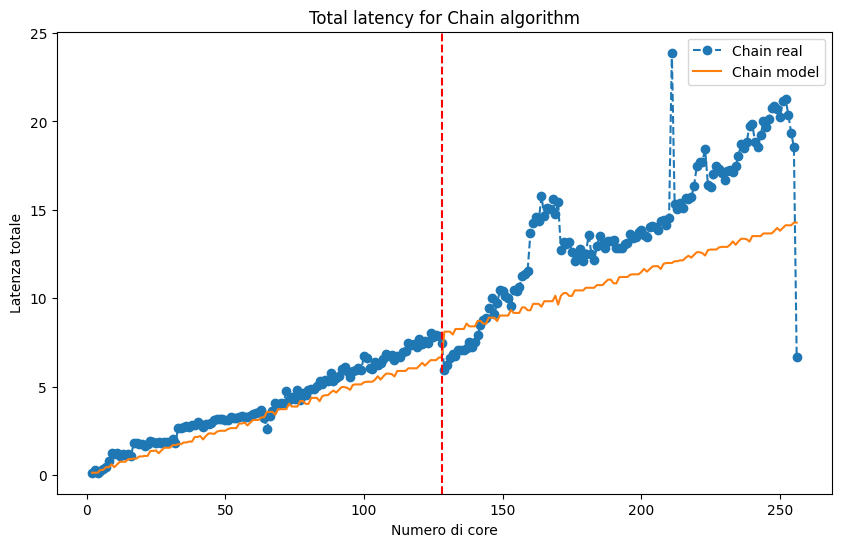

In [ ]:
def calculate_chain_latency_enhanced(matrix_times, num_cores, cores_per_node=128, fixed_fanout=4):
    """
    Enhanced latency calculation considering fixed fanout and node boundaries.

    :param matrix_times: Communication time matrix (2D list or numpy array)
                         matrix_times[i][j] should represent the time taken to send data from core i to core j.
    :param num_cores: Total number of cores used
    :param cores_per_node: Number of cores per node (default is 128)
    :param fixed_fanout: Fixed fanout value (default is 4)
    :return: Total broadcast latency in microseconds
    """
    if num_cores <= 0:
        raise ValueError("The number of cores must be at least 1.")

    # Calculate the number of nodes
    num_nodes = math.ceil(num_cores / cores_per_node)
    
    # Calculate the total number of chains (fixed fanout)
    total_chains = fixed_fanout
    
    # Calculate the number of non-root processes
    P = num_cores - 1  # assuming root is core 0
    
    # Handle the special case where there are no non-root processes
    if P == 0:
        return 0.0  # No latency if there's only the root

    # Ensure chains do not exceed number of processes
    total_chains = min(total_chains, P)
    
    # Determine the size of each chain
    base_chain_size = P // total_chains
    remainder = P % total_chains

    # Initialize latency for each chain
    chain_latencies = []

    # Assign processes to chains in contiguous blocks
    # Processes are numbered from 1 to num_cores-1 (assuming root is 0)
    processes = list(range(1, num_cores))
    
    start = 0
    for chain in range(total_chains):
        # Distribute the remainder across the first 'remainder' chains
        chain_size = base_chain_size + 1 if chain < remainder else base_chain_size
        end = start + chain_size
        chain_processes = processes[start:end]
        
        if len(chain_processes) > 0:
            # The first process in the chain receives data from the root
            first_process = chain_processes[0]
            chain_latency = matrix_times[0][first_process]
            
            # Determine if the first process is on a different node
            first_node = (first_process - 1) // cores_per_node
            root_node = 0  # assuming root is on node 0
            if first_node != root_node:
                # If the first process is on a different node, include inter-node communication time
                chain_latency = matrix_times[0][first_process]
            
            # Each subsequent process receives data from the previous process in the chain
            for i in range(1, len(chain_processes)):
                prev_core = chain_processes[i - 1]
                curr_core = chain_processes[i]
                chain_latency += matrix_times[prev_core][curr_core]
        
            chain_latencies.append(chain_latency)
        
        start = end

    # The total latency is the maximum latency among all chains
    total_latency = max(chain_latencies) * 1e6  # Convert to microseconds
    return total_latency

# Calcolare la latenza totale per diverse dimensioni del comunicatore
latency_results = {}
for num_cores in range(2, 257):  # da 2 fino a 256 core
    latency_results[num_cores] = calculate_chain_latency_enhanced(MATRIX_TIMES, num_cores)
    
# plot dei risultati
plt.figure(figsize=(10, 6))
plt.plot(df2['Processes'], df2['Latency'], marker='o', linestyle='dashed', label='Chain real')
plt.plot(latency_results.keys(), latency_results.values())
plt.axvline(x=128, color='r', linestyle='--', label='128 cores')
plt.legend(['Chain real', 'Chain model'])
plt.xlabel('Numero di core')
plt.ylabel('Latenza totale')
plt.title('Total latency for Chain algorithm')
plt.show()


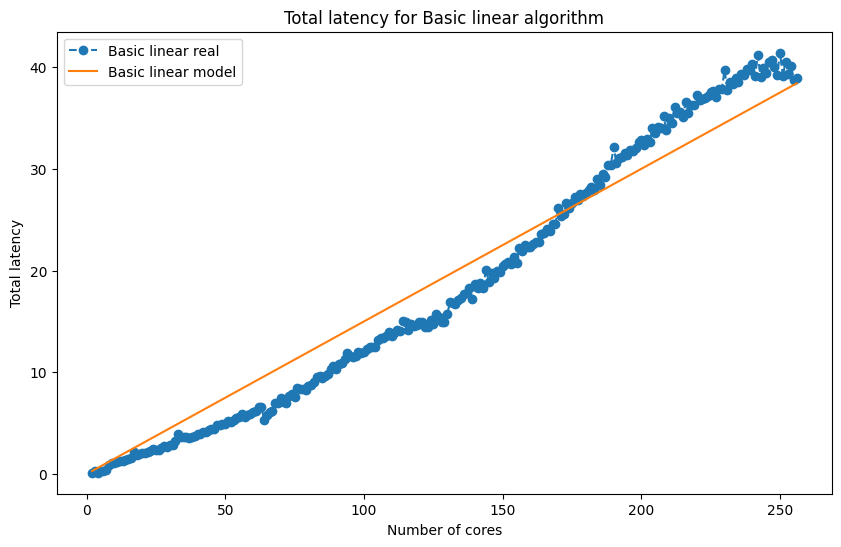

In [ ]:
# Basic linear

import math

def basic_linear_nonblocking_with_overhead_corrected(matrix, num_cores, root=0, 
                                                     overhead_per_core=0.15):
    """
    Calcola la latenza totale del broadcast utilizzando invii non bloccanti,
    considerando un overhead che aumenta linearmente con il numero di core.

    :param matrix: Matrice dei tempi di comunicazione (2D list o numpy array) in unità specificata
    :param num_cores: Numero totale di core utilizzati
    :param root: Rank del processo root (default=0)
    :param overhead_per_core: Overhead aggiuntivo per ciascun core, in unità specificate
    :param unit: Unità di tempo dei dati della matrice ('s', 'ms', 'us')
    :return: Latenza totale del broadcast in microsecondi
    """


    # Estrai i tempi di invio dal root a tutti gli altri core
    send_times = [matrix[root][i] for i in range(num_cores) if i != root]
    
    # Debug: stampa i tempi di invio
    #print(f"Tempi di invio dal root (rank {root}): {send_times}")
    
    # Calcola il tempo massimo di invio
    if send_times:
        max_time = max(send_times)
        #print(f"Tempo massimo di invio: {max_time} {unit}")
    else:
        max_time = 0
        #print("Nessun invio necessario (numero di core = 1).")
    
    # Calcola l'overhead totale basato sul numero di core
    total_overhead = overhead_per_core * num_cores
    #print(f"Overhead totale: {total_overhead} {unit}")
    
    # Calcola la latenza totale come il tempo massimo di invio più l'overhead
    total_time = max_time + total_overhead
    
    # Converti in microsecondi
    total_latency = total_time
    #print(f"Latenza totale del broadcast: {total_latency} µs")
    
    return total_latency



# Calculate the total latency for different communicator sizes
latency_results = {}
for num_cores in range(2, 257):  # from 2 up to 256 cores
    latency_results[num_cores] = basic_linear_nonblocking_with_overhead_corrected(MATRIX_TIMES, num_cores)

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(df1['Processes'], df1['Latency'], marker='o', linestyle='dashed', label='Basic linear real')
plt.plot(latency_results.keys(), latency_results.values())
plt.legend(['Basic linear real', 'Basic linear model'])
plt.xlabel('Number of cores')
plt.ylabel('Total latency')
plt.title('Total latency for Basic linear algorithm')
plt.show()


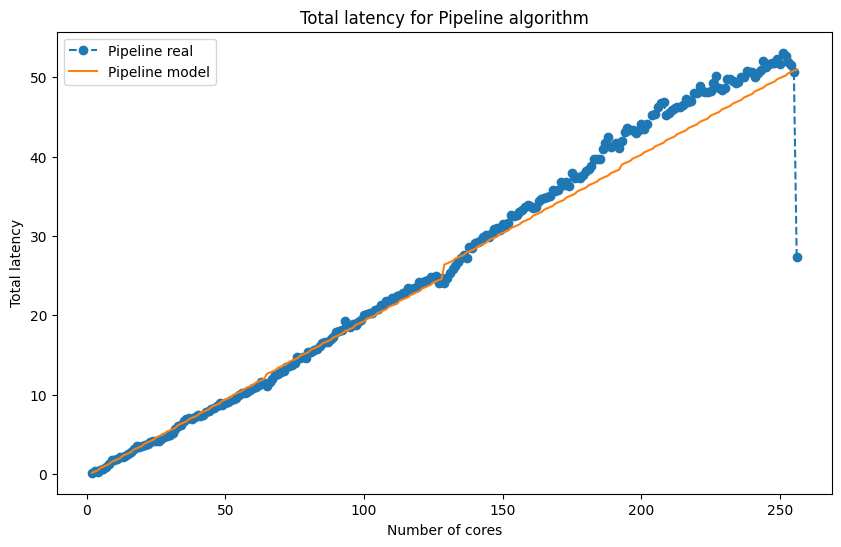

In [ ]:
def pipeline_broadcast(matrix, num_cores, k=4):
    """
    Calcola il tempo totale per l'algoritmo Pipeline Broadcast.

    Parameters:
    - matrix (list of lists): Matrice dei tempi di comunicazione point-to-point.
    - num_cores (int): Numero di core coinvolti nel broadcast.
    - k (int): Numero di segmenti (default è 4).

    Returns:
    - float: Tempo totale di broadcast in microsecondi.
    """
    t = 0
    # Tempo per inviare il primo segmento attraverso tutta la catena
    for i in range(num_cores - 1):
        t += matrix[i][i + 1]
    
    # Tempo per inviare i restanti (k - 1) segmenti in pipelining
    # Assumiamo che ogni nuovo segmento inizi a essere inviato non appena il segmento precedente si è spostato avanti
    # Il tempo aggiuntivo per ogni nuovo segmento è il tempo del primo link
    
    return t * 1e6  # Convertiamo il tempo in microsecondi

# Calculate the total latency for different communicator sizes
latency_results = {}
for num_cores in range(2, 257):  # from 2 up to 256 cores
    latency_results[num_cores] = pipeline_broadcast(MATRIX_TIMES, num_cores)

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(df3['Processes'], df3['Latency'], marker='o', linestyle='dashed', label='Pipeline real')
plt.plot(latency_results.keys(), latency_results.values())
plt.legend(['Pipeline real', 'Pipeline model'])
plt.xlabel('Number of cores')
plt.ylabel('Total latency')
plt.title('Total latency for Pipeline algorithm')
plt.show()